In [14]:
%config Completer.use_jedi = False
import os, mne
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib import gridspec
import seaborn as sns
from datetime import datetime
from tqdm.notebook import tqdm
import json
from scipy import stats
from copy import deepcopy
from sklearn.metrics import * 
from sklearn.utils import check_random_state
from collections import Counter, defaultdict

plt.rc('text', usetex=True) 

font = {'family' : 'serif',
        'size'   : '20',
        'serif' : ['Computer Modern'],
        'sans-serif' : ['Computer Modern']}  

plt.rc('font', **font)
plt.rc('axes', titlesize=28, labelsize=20)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=16)  

save_dir = 'C:/Users/andersgm/Documents/Courses/02466 Project work F21/Project/Plots/'

#sns.set_style("whitegrid")

In [81]:
class StratifiedGroupKFold():

    def __init__(self, k=10, n_repeats=1, seed=None):
        self.k = k  # Number of folds
        self.n_repeats = n_repeats  # Number of repeats
        self.seed = seed  # Random seed for reproducibility

    # Implementation inspired by Kaggle
    # https://www.kaggle.com/jakubwasikowski/stratified-group-k-fold-cross-validation
    def split(self, X, y=None, groups=None):
        random_state = check_random_state(self.seed)  # Random state generator

        # Repeat k-fold n_splits time with unique folds
        for repeat in range(self.n_repeats):
            labels_num = len(np.unique(y))  # Number of labels

            # Calculate the label distribution for each group
            y_counts_per_group = defaultdict(lambda: np.zeros(labels_num, dtype=int))
            y_distr = Counter()

            for label, g in zip(y, groups):
                y_counts_per_group[g][label] += 1
                y_distr[label] += 1

            fold_counts = defaultdict(lambda: np.zeros(labels_num, dtype=int))
            groups_per_fold = defaultdict(set)

            # Shuffle the groups
            label_counts = list(y_counts_per_group.items())
            random_state.shuffle(label_counts)

            '''
            For each group and its label distribution add the group to the
            fold that would cause the least standard deviation from the
            original distribution.
            '''

            for g, label_counts in label_counts:
                best_fold = None
                min_eval = None
                for fold in range(self.k):
                    fold_counts[fold] += label_counts
                    std_per_label = []
                    for l in range(labels_num):
                        label_std = np.std([fold_counts[i][l] / y_distr[l] for i in range(self.k)])
                        std_per_label.append(label_std)

                    fold_counts[fold] -= label_counts

                    fold_eval = np.mean(std_per_label)

                    if min_eval == None or fold_eval < min_eval:
                        min_eval = fold_eval
                        best_fold = fold

                fold_counts[best_fold] += label_counts
                groups_per_fold[best_fold].add(g)

            all_groups = np.unique(groups)  # Get all unique groups
            for fold in range(self.k):
                train_groups = np.setdiff1d(all_groups, list(groups_per_fold[fold]))
                test_groups = list(groups_per_fold[fold])

                train_indices = np.where(np.isin(groups, list(train_groups)))[0]
                test_indices = np.where(np.isin(groups, list(test_groups)))[0]
                
                random_state.shuffle(train_indices)
                random_state.shuffle(test_indices)
                
                # Yields the indices as they are needed
                yield repeat, fold, train_indices, test_indices

# Raw results

In [500]:
ytrue = np.load("multiclass_y_new.npy")

In [509]:
import os 
result_files = []

for root, dirs, files in os.walk(r"C:\Users\andersgm\Documents\Courses\02466 Project work F21\Project\Final results\Raw"):
    for file in files:
        if file.endswith(".npy"):
             result_files.append(root + "\\" + file)

In [25]:
def mean_conf(a, confidence=0.95):
    return stats.sem(a) * stats.t.ppf((1 + confidence) / 2, len(a)-1)

In [87]:
label_dict = {'chew': 0, 'elpp': 1, 'eyem': 2, 'musc': 3, 'shiv': 4, 'null': 5}
index_dict = {0: 'chew', 1: 'elpp', 2: 'eyem', 3: 'musc', 4: 'shiv', 5: 'null'}

In [505]:
result_files = []

for root, dirs, files in os.walk(r"C:\Users\andersgm\Documents\Courses\02466 Project work F21\Project\Final results\Filtered"):
    for file in files:
        if file.endswith(".npy"):
             result_files.append(root + "\\" + file)
                
for file in result_files:
    ypred = np.load(file)
    if "LDA" in file.split("\\")[-1]:
        recall = np.empty((6, 5))
        precision = np.empty((6, 5))
        f1 = np.empty(5)
        f2 = np.empty(5)
        acc = np.empty(5)

        for i in range(5):
            report = classification_report(ytrue, ypred[i], output_dict=True, target_names=list(label_dict.keys()))
            for label in label_dict.keys():
                recall[label_dict[label]][i] = report[label]['recall']
                precision[label_dict[label]][i] = report[label]['precision']

            f1[i] = report['weighted avg']['f1-score']
            f2[i] = fbeta_score(ytrue, ypred[i], beta=2, average="weighted")
            acc[i] = balanced_accuracy_score(ytrue, ypred[i])
            
        print("${:.2f}$".format(f1.mean()), end="\t")
        print("${:.2f}$".format(f2.mean()), end="\t")
        print("${:.2f}$".format(acc.mean()), end="\t")
        for label in label_dict.keys():
            print("${:.2f}$".format(recall[label_dict[label]].mean()), end="\t")
        print()

$0.80$	$0.75$	$0.34$	$0.21$	$0.14$	$0.64$	$0.28$	$0.00$	$0.75$	
$0.63$	$0.54$	$0.31$	$0.19$	$0.20$	$0.74$	$0.24$	$0.00$	$0.52$	
$0.86$	$0.83$	$0.31$	$0.23$	$0.18$	$0.41$	$0.18$	$0.02$	$0.85$	
$0.72$	$0.65$	$0.30$	$0.19$	$0.28$	$0.53$	$0.13$	$0.01$	$0.64$	
$0.86$	$0.84$	$0.31$	$0.23$	$0.19$	$0.39$	$0.17$	$0.02$	$0.86$	
$0.73$	$0.66$	$0.30$	$0.18$	$0.29$	$0.53$	$0.13$	$0.01$	$0.65$	


In [510]:

for file in result_files:
    ypred = np.load(file)
    if "MLP" in file.split("\\")[-1]:
        recall = np.empty((6, 5))
        precision = np.empty((6, 5))
        f1 = np.empty(5)
        f2 = np.empty(5)
        acc = np.empty(5)

        for i in range(5):
            report = classification_report(ytrue, ypred[i], output_dict=True, target_names=list(label_dict.keys()))
            for label in label_dict.keys():
                recall[label_dict[label]][i] = report[label]['recall']
                precision[label_dict[label]][i] = report[label]['precision']

            f1[i] = report['weighted avg']['f1-score']
            f2[i] = fbeta_score(ytrue, ypred[i], beta=2, average="weighted")
            acc[i] = balanced_accuracy_score(ytrue, ypred[i])
            
        print("${:.2f} \pm {:.2f}$".format(f1.mean(), mean_conf(f1)), end="\t")
        print("${:.2f} \pm {:.2f}$".format(f2.mean(), mean_conf(f2)), end="\t")
        print("${:.2f} \pm {:.2f}$".format(acc.mean(), mean_conf(acc)), end="\t")
        for label in label_dict.keys():
            print("${:.2f} \pm {:.2f}$".format(recall[label_dict[label]].mean(), mean_conf(recall[label_dict[label]])), end="\t")
        print()

$0.48 \pm 0.01$	$0.38 \pm 0.01$	$0.38 \pm 0.01$	$0.37 \pm 0.02$	$0.30 \pm 0.01$	$0.75 \pm 0.02$	$0.44 \pm 0.02$	$0.09 \pm 0.02$	$0.34 \pm 0.01$	
$0.04 \pm 0.01$	$0.03 \pm 0.01$	$0.35 \pm 0.01$	$0.35 \pm 0.03$	$0.36 \pm 0.04$	$0.83 \pm 0.02$	$0.46 \pm 0.04$	$0.05 \pm 0.02$	$0.02 \pm 0.01$	
$0.54 \pm 0.01$	$0.44 \pm 0.01$	$0.36 \pm 0.01$	$0.36 \pm 0.03$	$0.34 \pm 0.02$	$0.63 \pm 0.01$	$0.36 \pm 0.01$	$0.10 \pm 0.05$	$0.40 \pm 0.01$	
$0.14 \pm 0.01$	$0.09 \pm 0.01$	$0.33 \pm 0.01$	$0.34 \pm 0.03$	$0.41 \pm 0.02$	$0.70 \pm 0.01$	$0.36 \pm 0.02$	$0.07 \pm 0.02$	$0.08 \pm 0.01$	
$0.56 \pm 0.02$	$0.46 \pm 0.02$	$0.37 \pm 0.02$	$0.37 \pm 0.04$	$0.35 \pm 0.02$	$0.59 \pm 0.01$	$0.34 \pm 0.03$	$0.13 \pm 0.07$	$0.43 \pm 0.02$	
$0.13 \pm 0.01$	$0.09 \pm 0.01$	$0.34 \pm 0.01$	$0.36 \pm 0.04$	$0.44 \pm 0.02$	$0.69 \pm 0.01$	$0.35 \pm 0.04$	$0.11 \pm 0.05$	$0.07 \pm 0.01$	


# Evaluation without filter

In [44]:
X = np.load("multiclass_X_new.npy")
y = np.load("multiclass_y_new.npy")
groups = np.load("multiclass_patients_new.npy")

In [132]:
result_files = []

for root, dirs, files in os.walk(r"C:\Users\andersgm\Documents\Courses\02466 Project work F21\Project\Final results\Raw"):
    for file in files:
        if file.endswith(".npy"):
             result_files.append(root + "\\" + file)

In [107]:
results = pd.DataFrame(columns=['f1', 'f2', 'bacc', 'chew', 'elpp', 'eyem', 'musc', 'shiv', 'null', 'method', 'algorithm', 'fold'])
pbar = tqdm(total=5*5*len(result_files))

for file in result_files:
    model = file.split("\\")[-1].split("_")[1]
    technique = int(file.split("\\")[-1].split("_")[2])
    ypred = np.load(file)

    for repeat, fold, par_idxs, val_idxs in StratifiedGroupKFold(k=5, n_repeats=5, seed=55784899).split(X, y, groups):
        report = classification_report(y[val_idxs], ypred[repeat][val_idxs], output_dict=True, target_names=list(label_dict.keys()))
        results = results.append({'f1' : fbeta_score(y[val_idxs], ypred[repeat][val_idxs], beta=1, average="weighted"),
                                  'f2' : fbeta_score(y[val_idxs], ypred[repeat][val_idxs], beta=2, average="weighted"),
                                  'bacc' : balanced_accuracy_score(y[val_idxs], ypred[repeat][val_idxs]),
                                  'chew' : report['chew']['recall'],
                                  'elpp' : report['elpp']['recall'],
                                  'eyem' : report['eyem']['recall'],
                                  'musc' : report['musc']['recall'],
                                  'shiv' : report['shiv']['recall'],
                                  'null' : report['null']['recall'],
                                  'method' : technique,
                                  'algorithm' : model,
                                  'fold' : repeat*5 + fold}, ignore_index=True)
        pbar.update(1)
    
    

  0%|          | 0/450 [00:00<?, ?it/s]

In [121]:
results.head()

,f1,f2,bacc,chew,elpp,eyem,musc,shiv,null,method,algorithm,fold
0,0.390091,0.295608,0.284746,0.167746,0.159597,0.857429,0.140113,0.119287,0.264305,0,GNB,0
1,0.472015,0.368279,0.331304,0.549458,0.095661,0.802791,0.132995,0.073457,0.333463,0,GNB,1
2,0.336281,0.246604,0.340955,0.240856,0.234973,0.790593,0.223414,0.341981,0.213913,0,GNB,2
3,0.359971,0.268021,0.464168,0.278744,0.271913,0.856016,0.199747,0.945148,0.233438,0,GNB,3
4,0.419760,0.320603,0.315148,0.340548,0.275000,0.852937,0.107719,0.029703,0.284978,0,GNB,4


In [119]:
results.to_csv("metric_results.csv")

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


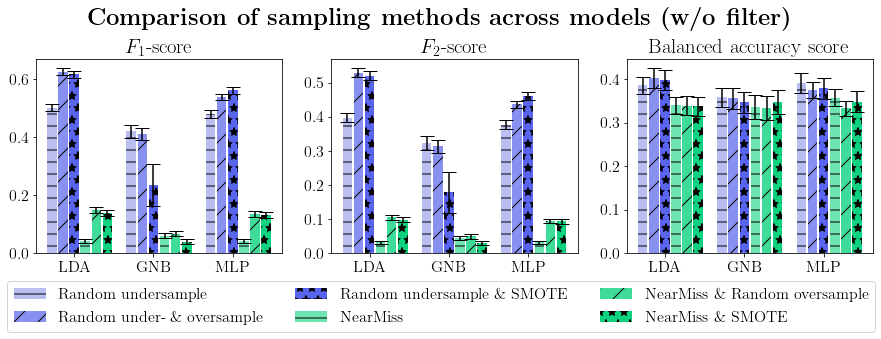

In [120]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

for j, metric in enumerate(['f1', 'f2', 'bacc']):

    bars = np.empty((6, 3))
    confs = np.empty((6, 3))

    for i, algorithm in enumerate(['LDA', 'GNB', 'MLP']):
        for method in range(6):
            bars[method, i] = np.mean(results[(results['method'] == method) & (results['algorithm'] == algorithm)][metric])
            confs[method, i] = mean_conf(results[(results['method'] == method) & (results['algorithm'] == algorithm)][metric])

    barWidth = 0.12
    colors = ["#b9bdf0", "#8991f0", "#5965ef", "#6ee4b2", "#3fdc99", "#0ed280"]
    techniques = ["Random undersample", "Random under- \& oversample", "Random undersample \& SMOTE", "NearMiss", "NearMiss \& Random oversample", "NearMiss \& SMOTE"]

    bars = bars[[0, 2, 4, 1, 3, 5]]
    confs = confs[[0, 2, 4, 1, 3, 5]]
    patterns = ["-" ,"/", "*", "-" ,"/", "*"]


    for i in range(6):
        r = np.arange(3) + barWidth*i + 0.02*i
        ax[j].bar(r, bars[i], width = barWidth, color = colors[i],
                yerr=confs[i], capsize=7, label=techniques[i], hatch=patterns[i])
    ax[j].set_xticks(np.arange(3)+0.28)
    ax[j].set_xticklabels(['LDA', 'GNB', 'MLP'])
    #plt.ylabel('height')
    
ax[0].title.set_text(r"\huge{$F_1$-score}")
ax[1].title.set_text(r"\huge{$F_2$-score}")
ax[2].title.set_text(r"\huge{Balanced accuracy score}")
ax[0].legend(ncol=3, bbox_to_anchor=(3.44, -0.10))
# Show graphic
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.8, wspace=None, hspace=None)
plt.suptitle(r"\textbf{Comparison of sampling methods across models (w/o filter)}")
plt.savefig(save_dir + "comparisons_across_models_without_filter.png", dpi=200, bbox_inches = 'tight')
plt.show()

In [163]:
algorithm = "GNB"

for method in range(6):
    result = results[(results["method"] == method) & (results["algorithm"] == algorithm)]
    print("${:.0f} \pm {:.0f}$".format(np.mean(result['f1'])*100, mean_conf(result['f1'])*100), end='\t')
    print("${:.0f} \pm {:.0f}$".format(np.mean(result['f2'])*100, mean_conf(result['f1'])*100), end='\t')
    print("${:.0f} \pm {:.0f}$".format(np.mean(result['bacc'])*100, mean_conf(result['f1'])*100), end='\t')
    for label in label_dict.keys():
        print("${:.0f} \pm {:.0f}$".format(np.mean(result[label])*100, mean_conf(result[label])*100), end='\t')
    print()

$42 \pm 2$	$32 \pm 2$	$36 \pm 2$	$32 \pm 6$	$21 \pm 3$	$83 \pm 2$	$18 \pm 3$	$32 \pm 13$	$29 \pm 2$	
$6 \pm 1$	$4 \pm 1$	$34 \pm 1$	$24 \pm 5$	$41 \pm 5$	$79 \pm 2$	$32 \pm 4$	$22 \pm 13$	$3 \pm 1$	
$41 \pm 2$	$31 \pm 2$	$36 \pm 2$	$32 \pm 6$	$23 \pm 3$	$81 \pm 2$	$16 \pm 3$	$33 \pm 14$	$28 \pm 2$	
$7 \pm 1$	$5 \pm 1$	$33 \pm 1$	$24 \pm 5$	$42 \pm 5$	$78 \pm 2$	$30 \pm 4$	$23 \pm 13$	$4 \pm 1$	
$24 \pm 7$	$18 \pm 7$	$35 \pm 7$	$29 \pm 5$	$33 \pm 5$	$76 \pm 3$	$22 \pm 4$	$32 \pm 14$	$16 \pm 6$	
$4 \pm 1$	$3 \pm 1$	$35 \pm 1$	$24 \pm 6$	$39 \pm 6$	$82 \pm 2$	$41 \pm 5$	$21 \pm 12$	$2 \pm 0$	


# Evaluation with filter

In [133]:
result_files = []

for root, dirs, files in os.walk(r"C:\Users\andersgm\Documents\Courses\02466 Project work F21\Project\Final results\Filtered"):
    for file in files:
        if file.endswith(".npy"):
             result_files.append(root + "\\" + file)

results_filter = pd.DataFrame(columns=['f1', 'f2', 'bacc', 'chew', 'elpp', 'eyem', 'musc', 'shiv', 'null', 'method', 'algorithm', 'fold'])
pbar = tqdm(total=5*5*len(result_files))

for file in result_files:
    model = file.split("\\")[-1].split("_")[1]
    technique = int(file.split("\\")[-1].split("_")[2])
    ypred = np.load(file)

    for repeat, fold, par_idxs, val_idxs in StratifiedGroupKFold(k=5, n_repeats=5, seed=55784899).split(X, y, groups):
        report = classification_report(y[val_idxs], ypred[repeat][val_idxs], output_dict=True, target_names=list(label_dict.keys()))
        results_filter = results_filter.append({'f1' : fbeta_score(y[val_idxs], ypred[repeat][val_idxs], beta=1, average="weighted"),
                                  'f2' : fbeta_score(y[val_idxs], ypred[repeat][val_idxs], beta=2, average="weighted"),
                                  'bacc' : balanced_accuracy_score(y[val_idxs], ypred[repeat][val_idxs]),
                                  'chew' : report['chew']['recall'],
                                  'elpp' : report['elpp']['recall'],
                                  'eyem' : report['eyem']['recall'],
                                  'musc' : report['musc']['recall'],
                                  'shiv' : report['shiv']['recall'],
                                  'null' : report['null']['recall'],
                                  'method' : technique,
                                  'algorithm' : model,
                                  'fold' : repeat*5 + fold}, ignore_index=True)
        pbar.update(1)
    
    

  0%|          | 0/450 [00:00<?, ?it/s]

C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\U

C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\U

C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\U

C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\U

C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\U

C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\U

C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\U

C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\U

C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\U

C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\U

C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\U

C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\U

In [134]:
results_filter.head()

,f1,f2,bacc,chew,elpp,eyem,musc,shiv,null,method,algorithm,fold
0,0.716688,0.645855,0.258197,0.009308,0.081363,0.793079,0.022261,0.000000,0.643173,0,GNB,0
1,0.733216,0.658228,0.306688,0.449097,0.022189,0.678295,0.023950,0.020242,0.646357,0,GNB,1
2,0.657556,0.564874,0.342047,0.097308,0.218944,0.722133,0.155142,0.323113,0.535641,0,GNB,2
3,0.693368,0.609346,0.423645,0.062255,0.087182,0.792415,0.067089,0.945992,0.586940,0,GNB,3
4,0.654683,0.564465,0.267713,0.053391,0.154091,0.800266,0.058575,0.000000,0.539954,0,GNB,4


In [135]:
results_filter.to_csv("metric_results_filter.csv")

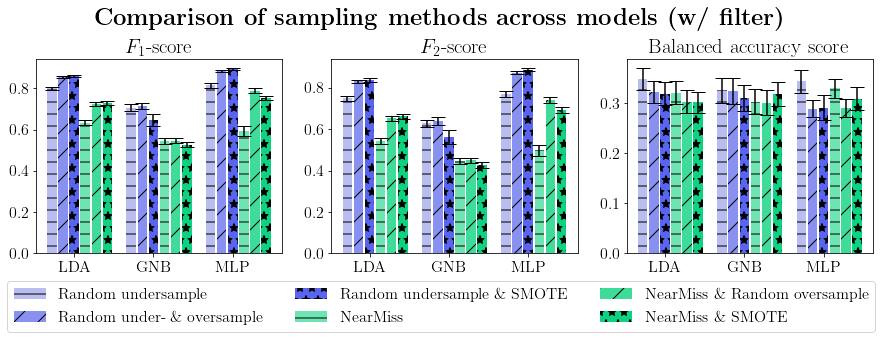

In [136]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

for j, metric in enumerate(['f1', 'f2', 'bacc']):

    bars = np.empty((6, 3))
    confs = np.empty((6, 3))

    for i, algorithm in enumerate(['LDA', 'GNB', 'MLP']):
        for method in range(6):
            bars[method, i] = np.mean(results_filter[(results['method'] == method) & (results['algorithm'] == algorithm)][metric])
            confs[method, i] = mean_conf(results_filter[(results['method'] == method) & (results['algorithm'] == algorithm)][metric])

    barWidth = 0.12
    colors = ["#b9bdf0", "#8991f0", "#5965ef", "#6ee4b2", "#3fdc99", "#0ed280"]
    techniques = ["Random undersample", "Random under- \& oversample", "Random undersample \& SMOTE", "NearMiss", "NearMiss \& Random oversample", "NearMiss \& SMOTE"]

    bars = bars[[0, 2, 4, 1, 3, 5]]
    confs = confs[[0, 2, 4, 1, 3, 5]]
    patterns = ["-" ,"/", "*", "-" ,"/", "*"]


    for i in range(6):
        r = np.arange(3) + barWidth*i + 0.02*i
        ax[j].bar(r, bars[i], width = barWidth, color = colors[i],
                yerr=confs[i], capsize=7, label=techniques[i], hatch=patterns[i])
    ax[j].set_xticks(np.arange(3)+0.28)
    ax[j].set_xticklabels(['LDA', 'GNB', 'MLP'])
    #plt.ylabel('height')
    
ax[0].title.set_text(r"\huge{$F_1$-score}")
ax[1].title.set_text(r"\huge{$F_2$-score}")
ax[2].title.set_text(r"\huge{Balanced accuracy score}")
ax[0].legend(ncol=3, bbox_to_anchor=(3.44, -0.10))
# Show graphic
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.8, wspace=None, hspace=None)
plt.suptitle(r"\textbf{Comparison of sampling methods across models (w/ filter)}")
plt.savefig(save_dir + "comparisons_across_models_with_filter.png", dpi=200, bbox_inches = 'tight')
plt.show()

In [166]:
algorithm = "MLP"

for method in range(6):
    result = results_filter[(results_filter["method"] == method) & (results_filter["algorithm"] == algorithm)]
    print("${:.0f} \pm {:.0f}$".format(np.mean(result['f1'])*100, mean_conf(result['f1'])*100), end='\t')
    print("${:.0f} \pm {:.0f}$".format(np.mean(result['f2'])*100, mean_conf(result['f1'])*100), end='\t')
    print("${:.0f} \pm {:.0f}$".format(np.mean(result['bacc'])*100, mean_conf(result['f1'])*100), end='\t')
    for label in label_dict.keys():
        print("${:.0f} \pm {:.0f}$".format(np.mean(result[label])*100, mean_conf(result[label])*100), end='\t')
    print()

$81 \pm 1$	$77 \pm 1$	$34 \pm 1$	$30 \pm 11$	$13 \pm 3$	$60 \pm 4$	$25 \pm 4$	$1 \pm 1$	$78 \pm 2$	
$59 \pm 2$	$50 \pm 2$	$33 \pm 2$	$28 \pm 9$	$19 \pm 5$	$77 \pm 3$	$27 \pm 4$	$0 \pm 0$	$47 \pm 3$	
$88 \pm 1$	$87 \pm 1$	$29 \pm 1$	$22 \pm 9$	$11 \pm 4$	$36 \pm 3$	$12 \pm 3$	$1 \pm 2$	$91 \pm 1$	
$79 \pm 1$	$74 \pm 1$	$29 \pm 1$	$16 \pm 8$	$18 \pm 5$	$54 \pm 3$	$13 \pm 3$	$0 \pm 0$	$74 \pm 2$	
$89 \pm 1$	$89 \pm 1$	$29 \pm 1$	$24 \pm 11$	$12 \pm 4$	$30 \pm 3$	$10 \pm 3$	$5 \pm 6$	$93 \pm 1$	
$75 \pm 1$	$69 \pm 1$	$31 \pm 1$	$22 \pm 10$	$23 \pm 5$	$54 \pm 3$	$14 \pm 2$	$3 \pm 4$	$69 \pm 2$	


# Statistical comparison

In [241]:
import statsmodels.stats.multitest

## Prefilter

In [256]:
pvalues = []
metric = 'f2'

for algorithm in ['LDA', 'GNB', 'MLP']:
    s24 = stats.wilcoxon(results[((results['method'] == 2) & (results['algorithm'] ==  algorithm))][metric].values,
                   results[((results['method'] == 4) & (results['algorithm'] == algorithm))][metric].values)
    
    s02 = stats.wilcoxon(results[((results['method'] == 0) & (results['algorithm'] ==  algorithm))][metric].values,
                   results[((results['method'] == 2) & (results['algorithm'] == algorithm))][metric].values)
    
    s04 = stats.wilcoxon(results[((results['method'] == 0) & (results['algorithm'] ==  algorithm))][metric].values,
                   results[((results['method'] == 4) & (results['algorithm'] == algorithm))][metric].values)
    
    pvalues.append(s24.pvalue)
    pvalues.append(s02.pvalue)
    pvalues.append(s04.pvalue)
    
pvalues = np.asarray(pvalues)

In [257]:
pvalues_corrected = statsmodels.stats.multitest.multipletests(pvalues)[1]

In [260]:
for i, algorithm in enumerate(['LDA', 'GNB', 'MLP']):
    d24 = np.mean(results[((results['method'] == 2) & (results['algorithm'] ==  algorithm))][metric].values -
                   results[((results['method'] == 4) & (results['algorithm'] == algorithm))][metric].values)
    if d24 < 0:
        print("2 < 4: ${:.2f}$ ${:.2e}$".format(d24*100, pvalues_corrected[3*i + 0]))
    else:
        print("4 < 2: ${:.2f}$ ${:.2e}$".format(d24*100, pvalues_corrected[3*i + 0]))
        
    d02 = np.mean(results[((results['method'] == 0) & (results['algorithm'] ==  algorithm))][metric].values -
                   results[((results['method'] == 2) & (results['algorithm'] == algorithm))][metric].values)
    if d02:
        print("0 < 2: ${:.2f}$ ${:.2e}$".format(d02*100, pvalues_corrected[3*i + 1]))
    else:
        print("2 < 0: ${:.2f}$ ${:.2e}$".format(d02*100, pvalues_corrected[3*i + 1]))
        
    d04 = np.mean(results[((results['method'] == 0) & (results['algorithm'] ==  algorithm))][metric].values -
                   results[((results['method'] == 4) & (results['algorithm'] == algorithm))][metric].values)
    if d04 < 0:
        print("0 < 4: ${:.2f}$ ${:.2e}$".format(d04*100, pvalues_corrected[3*i + 2]))
    else:
        print("4 < 0: ${:.2f}$ ${:.2e}$".format(d04*100, pvalues_corrected[3*i + 2]))

4 < 2: $0.93$ $7.54e-05$
0 < 2: $-13.12$ $5.36e-07$
0 < 4: $-12.19$ $5.36e-07$
4 < 2: $13.46$ $1.62e-03$
0 < 2: $0.88$ $1.91e-01$
4 < 0: $14.34$ $9.87e-04$
2 < 4: $-2.38$ $4.81e-04$
0 < 2: $-5.92$ $5.36e-07$
0 < 4: $-8.29$ $5.36e-07$


In [228]:
statsmodels.stats.multitest.multipletests(pvalues)[1]

array([5.03649102e-05, 5.36441675e-07, 5.36441675e-07, 7.52664984e-04,
       1.90814257e-01, 4.11923659e-04, 7.49222010e-04, 5.36441675e-07,
       5.36441675e-07])

In [139]:
results_filter

,f1,f2,bacc,chew,elpp,eyem,musc,shiv,null,method,algorithm,fold
0,0.716688,0.645855,0.258197,0.009308,0.081363,0.793079,0.022261,0.000000,0.643173,0,GNB,0
1,0.733216,0.658228,0.306688,0.449097,0.022189,0.678295,0.023950,0.020242,0.646357,0,GNB,1
2,0.657556,0.564874,0.342047,0.097308,0.218944,0.722133,0.155142,0.323113,0.535641,0,GNB,2
3,0.693368,0.609346,0.423645,0.062255,0.087182,0.792415,0.067089,0.945992,0.586940,0,GNB,3
4,0.654683,0.564465,0.267713,0.053391,0.154091,0.800266,0.058575,0.000000,0.539954,0,GNB,4
...,...,...,...,...,...,...,...,...,...,...,...,...
445,0.770165,0.721557,0.260470,0.000000,0.331093,0.469755,0.026941,0.000000,0.735033,5,MLP,20
446,0.758040,0.690454,0.348103,0.247111,0.451487,0.546707,0.167013,0.000000,0.676298,5,MLP,21
447,0.716430,0.643992,0.364466,0.636612,0.093356,0.611796,0.215657,0.000000,0.629376,5,MLP,22
448,0.790302,0.736135,0.280233,0.260970,0.117783,0.527738,0.039916,0.000000,0.734989,5,MLP,23


# Postfilter

In [249]:
pvalues = []
metric = 'f2'

for algorithm in ['LDA', 'GNB', 'MLP']:
    s24 = stats.wilcoxon(results_filter[((results_filter['method'] == 2) & (results_filter['algorithm'] ==  algorithm))][metric].values,
                   results_filter[((results_filter['method'] == 4) & (results_filter['algorithm'] == algorithm))][metric].values)
    
    s02 = stats.wilcoxon(results_filter[((results_filter['method'] == 0) & (results_filter['algorithm'] ==  algorithm))][metric].values,
                   results_filter[((results_filter['method'] == 2) & (results_filter['algorithm'] == algorithm))][metric].values)
    
    s04 = stats.wilcoxon(results_filter[((results_filter['method'] == 0) & (results_filter['algorithm'] ==  algorithm))][metric].values,
                   results_filter[((results_filter['method'] == 4) & (results_filter['algorithm'] == algorithm))][metric].values)
    
    pvalues.append(s24.pvalue)
    pvalues.append(s02.pvalue)
    pvalues.append(s04.pvalue)
    
pvalues = np.asarray(pvalues)

pvalues_corrected = statsmodels.stats.multitest.multipletests(pvalues)[1]

In [250]:
for i, algorithm in enumerate(['LDA', 'GNB', 'MLP']):
    if np.mean(results_filter[((results_filter['method'] == 2) & (results_filter['algorithm'] ==  algorithm))][metric].values -
                   results_filter[((results_filter['method'] == 4) & (results_filter['algorithm'] == algorithm))][metric].values) < 0:
        print("2 < 4:", pvalues_corrected[3*i + 0])
    else:
        print("4 < 2:", pvalues_corrected[3*i + 0])
        
    if np.mean(results_filter[((results_filter['method'] == 0) & (results_filter['algorithm'] ==  algorithm))][metric].values -
                   results_filter[((results_filter['method'] == 2) & (results_filter['algorithm'] == algorithm))][metric].values) < 0:
        print("0 < 2:", pvalues_corrected[3*i + 1])
    else:
        print("2 < 0:", pvalues_corrected[3*i + 1])
        
    if np.mean(results_filter[((results_filter['method'] == 0) & (results_filter['algorithm'] ==  algorithm))][metric].values -
                   results_filter[((results_filter['method'] == 4) & (results_filter['algorithm'] == algorithm))][metric].values) < 0:
        print("0 < 4:", pvalues_corrected[3*i + 2])
    else:
        print("4 < 0:", pvalues_corrected[3*i + 2])

2 < 4: 7.539760161867637e-05
0 < 2: 5.364416750808232e-07
0 < 4: 5.364416750808232e-07
4 < 2: 0.001615586490160581
0 < 2: 0.19081425666809082
4 < 0: 0.000986906891554007
2 < 4: 0.0004808035602023031
0 < 2: 5.364416750808232e-07
0 < 4: 5.364416750808232e-07


# Filter plots

In [383]:
def clean2(a):
    a = deepcopy(a)
    for n in range(2, 5):
        for i in range(n+1, len(a)-n*2-1):
            if np.all(a[i-n-1:i] == a[i-n-1]) and np.all(a[i-n-1] == a[i+n:i+2*n+1]):
                a[i:i+n] = a[i-n-1]

    for n in range(4, 14):
        mask = np.zeros(len(a))
        for i in range(len(a)-n):
            if np.all(a[i:i+n] == a[i]):
                mask[i:i+n] = True

        for i in range(len(a)):
            if not mask[i]:
                a[i] = 5
            
    return a

In [323]:
label_dict = {'chew': 0, 'elpp': 1, 'eyem': 2, 'musc': 3, 'shiv': 4, 'null': 5}
color_dict = {0: "#f5cf40", 1: "#e63f47", 2: "#0ed280", 3: "#fc7323", 4: "#79218f", 5: "#828bf2"} 
names = list(label_dict.keys())

In [324]:
hex_to_rgb = lambda s: [int(s[1:3], 16), int(s[3:5], 16), int(s[5:7], 16)] 
def plot_artifacts(ax, y, dataframe):
    image = []
    for label in y:
        image.append(hex_to_rgb(color_dict[label]))
    image = np.array(image)
    image = np.expand_dims(image, 0)
    image = np.tile(np.repeat(image, 2, axis=1), (1, 1, 1))
    ax.set_yticks([])
    ax.imshow(image, interpolation='none', extent=(0, len(y)/4, 0, len(y)/4*(1/15)))

In [325]:
df = pd.read_pickle("dataframe_float32.pkl")

In [537]:
ypred = np.load('C:\\Users\\andersgm\\Documents\\Courses\\02466 Project work F21\\Project\\Final results\\Raw\\predictions_LDA_4_5_5_5_55784899_08-06-21_01-03-16.npy')[0]
yfiltered = np.load('C:\\Users\\andersgm\\Documents\\Courses\\02466 Project work F21\\Project\\Final results\\Filtered\\predictions_LDA_4_5_5_5_55784899_08-06-21_01-03-16_filtered.npy')[0]

In [384]:
cherry_picked_patients = ["00000254_s005_t000", "00009320_s001_t000", "00010024_s001_t000", "00009335_s002_t000", "00009485_s001_t000", "00008476_s001_t000", "00005740_s003_t000", "00003367_s003_t001", "00008723_s001_t000"]
p_index = 0

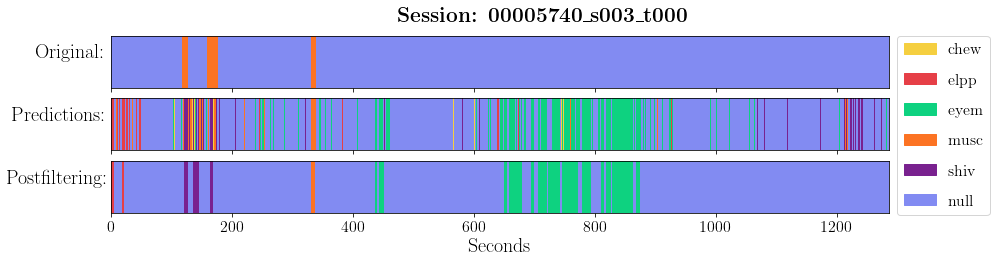

In [408]:
#patient_name = np.random.choice( np.unique(df["Name"]))
#patient_name = '00009362_s001_t001'
patient_name = cherry_picked_patients[p_index]
p_index += 1
patient = deepcopy(df[df["Name"] == patient_name])
patient = patient.sort_values(by="Start", ascending=True, key=lambda col: col.values).reset_index(drop=True)

prediction = ypred[patient["index"].values]

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12,3), sharex=True)

plot_artifacts(ax[0], ytrue[patient["index"].values], patient)
ax[0].set_ylabel("Original:", rotation=0, labelpad=41.0)
plot_artifacts(ax[1], ypred[patient["index"].values], patient)
ax[1].set_ylabel("Predictions:", rotation=0, labelpad=52.0)
plot_artifacts(ax[2], clean2(ypred[patient["index"].values]), patient)
ax[2].set_ylabel(r"Postfiltering:", rotation=0, labelpad=53.0)

#ax[0].title.set_text("{\\huge %s" % (patient_name.replace("_", "\\_")))

ax[2].set_xlabel("Seconds")    
plt.subplots_adjust(left=0.0,
                    bottom=0.0, 
                    right=0.9, 
                    top=0.87, 
                    wspace=0.4, 
                    hspace=0.0)
handles = []
for i in range(6):
    handles.append(mpatches.Patch(color=color_dict[i], label=names[i]))

ax[0].legend(handles=handles, ncol=1, bbox_to_anchor=(1.14, 1.16), labelspacing=0.95) 

plt.suptitle(r"\textbf{Session: %s}" % patient_name.replace("_", "\\_"), size=21)
plt.savefig(save_dir + "session_{}.png".format(patient_name), dpi=200, bbox_inches = 'tight')
plt.show()

In [412]:
fbeta_score(ytrue[patient["index"].values], clean2(ypred[patient["index"].values]), beta=2, average="weighted")

0.8516053184694593

In [413]:
balanced_accuracy_score(ytrue[patient["index"].values], clean2(ypred[patient["index"].values]))

C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


0.5025492554680252

# Compare with v2.0.0

In [514]:
dfv2 = pd.read_pickle("dataframe_float32_new_v2.pkl")

In [551]:
patient_name = '00007078_s001_t000'

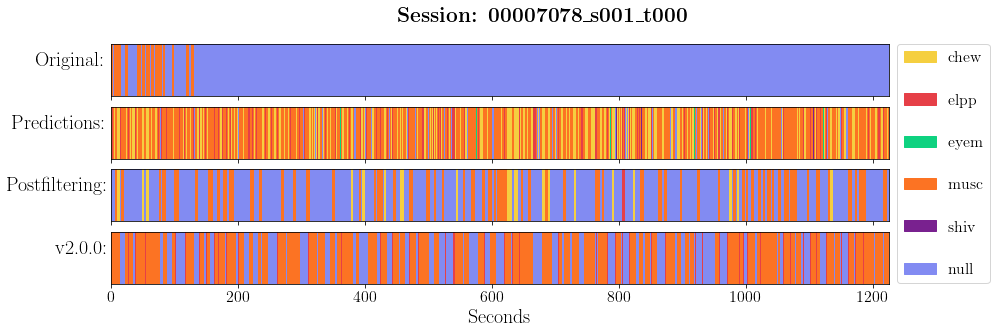

In [553]:
#patient_name = '00002348_s014_t008'

#patient_name = cherry_picked_patients[p_index]
#p_index += 1
#patient_name = np.random.choice( np.unique(df["Name"]))
patient = deepcopy(df[df["Name"] == patient_name])
patient = patient.sort_values(by="Start", ascending=True, key=lambda col: col.values).reset_index(drop=True)

patient2 = deepcopy(dfv2[dfv2["Name"] == patient_name])
patient2 = patient2.sort_values(by="Start", ascending=True, key=lambda col: col.values).reset_index(drop=True)

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(12,4), sharex=True)

plot_artifacts(ax[0], ytrue[patient["index"].values], patient)
ax[0].set_ylabel("Original:", rotation=0, labelpad=41.0)
plot_artifacts(ax[1], ypred[patient["index"].values], patient)
ax[1].set_ylabel("Predictions:", rotation=0, labelpad=52.0)
plot_artifacts(ax[2], clean2(ypred[patient["index"].values]), patient)
ax[2].set_ylabel(r"Postfiltering:", rotation=0, labelpad=53.0)
plot_artifacts(ax[3], patient2["Multiclass label v2"], patient)
ax[3].set_ylabel(r"v2.0.0:", rotation=0, labelpad=30.0)

#ax[0].title.set_text("{\\huge %s" % (patient_name.replace("_", "\\_")))

ax[3].set_xlabel("Seconds")    
plt.subplots_adjust(left=0.0,
                    bottom=0.0, 
                    right=0.9, 
                    top=0.87, 
                    wspace=0.4, 
                    hspace=0.0)
handles = []
for i in range(6):
    handles.append(mpatches.Patch(color=color_dict[i], label=names[i]))

ax[0].legend(handles=handles, ncol=1, bbox_to_anchor=(1.14, 1.16), labelspacing=1.7) 

plt.suptitle(r"\textbf{Session: %s}" % patient_name.replace("_", "\\_"), size=21)
plt.savefig(save_dir + "session_{}_v2.png".format(patient_name), dpi=200, bbox_inches = 'tight')
plt.show()

In [560]:
balanced_accuracy_score(patient2["Multiclass label v2"], clean2(ypred[patient["index"].values]))

C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


0.3446088423964992

In [559]:
balanced_accuracy_score(ytrue[patient["index"].values], clean2(ypred[patient["index"].values]))

C:\Users\andersgm\anaconda3\envs\epilepsy\lib\site-packages\sklearn\metrics\_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


0.41342752213468936

In [556]:
fbeta_score(patient2["Multiclass label v2"], ypred[patient["index"].values], beta=1, average='weighted')

0.402316631978493

In [554]:
fbeta_score(ytrue[patient["index"].values], clean2(ypred[patient["index"].values]), beta=1, average='weighted')

0.7466376188237479

In [555]:
fbeta_score(patient2["Multiclass label v2"], clean2(ypred[patient["index"].values]), beta=1, average='weighted')

0.3958199794994356

In [550]:
patient_name

'00007078_s001_t000'

In [339]:
dfv2[dfv2['Name'] == '00002348_s014_t008']

,index,Name,Start,End,Labels,Window,Multiclass label,Session group,Patient group,Multiclass label v2
107952,107952,00002348_s014_t008,0.00,1.00,[null],"[[0.29404157, 1.156163, 1.3178558, -0.06833511...",5,31,17,5
107953,107953,00002348_s014_t008,0.25,1.25,[null],"[[1.3079119, 0.16858682, 0.9286362, 0.7610758,...",5,31,17,5
107954,107954,00002348_s014_t008,0.50,1.50,[null],"[[0.5531869, -0.37649807, 0.8204341, 0.25315, ...",5,31,17,5
107955,107955,00002348_s014_t008,0.75,1.75,[null],"[[-0.87464076, 0.25594842, 0.5045968, 0.777981...",5,31,17,5
107956,107956,00002348_s014_t008,1.00,2.00,[null],"[[0.09673949, -0.35241073, 0.87030274, -0.1378...",5,31,17,5
...,...,...,...,...,...,...,...,...,...,...
112988,112988,00002348_s014_t008,998.75,999.75,[null],"[[0.1282383, -0.21968661, -0.62705415, -0.2760...",5,31,17,3
112989,112989,00002348_s014_t008,999.00,1000.00,[null],"[[0.45949912, -0.5734527, -0.314824, -0.406377...",5,31,17,3
112990,112990,00002348_s014_t008,999.25,1000.25,[null],"[[-0.42479828, 0.070886225, -0.21513507, -0.37...",5,31,17,3
112991,112991,00002348_s014_t008,999.50,1000.50,[null],"[[-0.49257106, -0.63827354, -0.27921182, -0.34...",5,31,17,3


# Metrics

In [8]:
ytrue = np.load("multiclass_y_new.npy")

In [485]:
result_files[10]

'C:\\Users\\andersgm\\Documents\\Courses\\02466 Project work F21\\Project\\Final results\\Raw\\predictions_LDA_4_5_5_5_55784899_08-06-21_01-03-16.npy'

In [6]:
file = 'C:\\Users\\andersgm\\Documents\\Courses\\02466 Project work F21\\Project\\Final results\\Raw\\predictions_LDA_4_5_5_5_55784899_08-06-21_01-03-16.npy'

In [493]:
file = 'C:\\Users\\andersgm\\Documents\\Courses\\02466 Project work F21\\Project\\Final results\\Filtered\\predictions_LDA_4_5_5_5_55784899_08-06-21_01-03-16_filtered.npy'

In [7]:
ypred = np.load(file)[0]

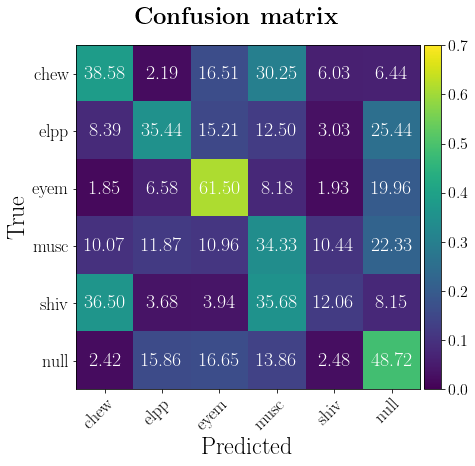

In [44]:
fig, ax = plt.subplots(figsize=(7,7))

m = confusion_matrix(ytrue, ypred, normalize='true')

im = ax.imshow(m, vmin=0, vmax=0.7)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax) 
# We want to show all ticks...
ax.set_xticks(np.arange(6))
ax.set_yticks(np.arange(6))
# ... and label them with the respective list entries
ax.set_xticklabels(list(label_dict.keys()), size=18)
ax.set_yticklabels(list(label_dict.keys()), size=18)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(6):
    for j in range(6):
        text = ax.text(j, i, "{:.2f}%".format(m[i, j]*100),
                       ha="center", va="center", color="w")

#ax.set_title("Harvest of local farmers (in tons/year)")
ax.set_xlabel("Predicted", size=24)
ax.set_ylabel("True", size=24)
fig.tight_layout()
plt.suptitle(r"\textbf{Confusion matrix}")
plt.savefig(save_dir + "confussion_matrix.png", dpi=200, bbox_inches = 'tight')
plt.show()

In [12]:
from copy import deepcopy

In [13]:
ytrue1 = deepcopy(ytrue)
ypred1 = deepcopy(ypred)

In [14]:
ytrue1[np.isin(ytrue1, [0,3,4])] = 0
ypred1[np.isin(ypred1, [0,3,4])] = 0

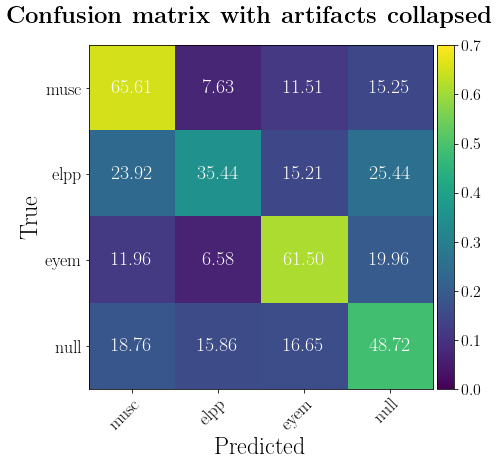

In [45]:
fig, ax = plt.subplots(figsize=(7,7))

m = confusion_matrix(ytrue1, ypred1, normalize='true')

im = ax.imshow(m, vmin=0, vmax=0.7)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax)

# We want to show all ticks...
ax.set_xticks(np.arange(4))
ax.set_yticks(np.arange(4))
# ... and label them with the respective list entries
ax.set_xticklabels(['musc', 'elpp', 'eyem', 'null'], size=18)
ax.set_yticklabels(['musc', 'elpp', 'eyem', 'null'], size=18)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(4):
    for j in range(4):
        text = ax.text(j, i, "{:.2f}%".format(m[i, j]*100),
                       ha="center", va="center", color="w")

#ax.set_title("Harvest of local farmers (in tons/year)")
ax.set_xlabel("Predicted", size=24)
ax.set_ylabel("True", size=24)
fig.tight_layout()
plt.suptitle(r"\textbf{Confusion matrix with artifacts collapsed}")
plt.savefig(save_dir + "confussion_matrix_collapsed.png", dpi=200, bbox_inches = 'tight')
plt.show()

In [474]:
balanced_accuracy_score(ytrue1, ypred1)

0.4950889639006151

In [475]:
balanced_accuracy_score(ytrue, ypred)

0.37907267363541264

In [473]:
f1_score(ytrue1, ypred1, average='weighted')

0.5603292381991456

In [463]:
f1_score(ytrue, ypred, average='weighted')

0.5587457563402912

In [449]:
np.mean(ypred[ytrue == 0] == 5)

0.100446812167039

In [443]:
np.mean(ypred[ytrue == 2] == 5 )

0.19923383484197843

In [ ]:
TP = np.sum(ypred[ytrue != 5] != 5)

In [151]:
TP = np.sum(ytrue[ytrue != 5] == ypred[ytrue != 5])

In [153]:
FP = np.sum(ypred[ytrue == 5] != 5)

In [154]:
FN = np.sum(ypred[ytrue != 5] == 5)

In [155]:
p = TP / (TP + FP)

In [156]:
r = TP / (TP + FN)

In [1]:
beta = 2

In [159]:
((1 + beta**2) * p * r) / (beta**2 * p + r)

0.31606537590395095

In [121]:
fbeta_score(ytrue, ypred, beta=1, average='weighted')

0.6174025192026655

In [122]:
np.mean(ypred[ytrue == 5] == 5)

0.4871876126972922

In [160]:
np.mean(ypred[ytrue != 5] != 5)

0.8143614260017142

In [162]:
path = 'C:\\Users\\andersgm\\Documents\\Courses\\02466 Project work F21\\Project\\Final results\\Filtered\\predictions_LDA_4_5_5_5_55784899_08-06-21_01-03-16_filtered.npy'
ypred = np.load(path)[0]

In [169]:
np.sum(ypred[ytrue != 5] != 5)

28582

In [181]:
TP = np.sum(ytrue[ytrue != 5] == ypred[ytrue != 5])
print(TP)

21529


In [182]:
FP = np.sum(ypred[ytrue == 5] != 5)
print(FP)

193008


In [183]:
FN = np.sum(ypred[ytrue != 5] == 5)
print(FN)

54251


In [184]:
p = TP / (TP + FP)

In [185]:
r = TP / (TP + FN)

In [186]:
2 * ((p * r) / (p + r))

0.14831373980855408

In [187]:
((1 + beta**2) * p * r) / (beta**2 * p + r)

0.20794657466237296

In [189]:
fbeta_score(ytrue, ytrue, beta=1, average='weighted')

1.0

In [314]:
y = np.load("multiclass_y_new.npy")
a = 0.5
y[np.random.choice(np.where(y == 5)[0], int(a*np.sum(y == 5)), replace=False)] = np.random.choice([0,1,2,3,4], int(a*np.sum(y == 5)))

In [302]:
y = np.load("multiclass_y_new.npy")
a = 0.5
y[np.random.choice(np.where(y != 5)[0], int(a*np.sum(y != 5)), replace=False)] = 5

In [315]:
fbeta_score(ytrue, y, beta=2, average='macro')

0.3945301123256894

In [321]:
fbeta_score(ytrue, np.zeros(ytrue.shape), beta=2, average='macro')

0.00676948276684431